## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
#%load_ext autoreload
#%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
import time

Load model parameters:

In [3]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Xception_local.json'

if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
p.keys()

dict_keys(['_comment', 'model_path', 'model_dir', 'clean_model_dir', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'random_CenterZoom', 'disable_gpu', 'set_memory_growth', 'model_name', 'pre_training', 'freez_pretrain', 'dense_reg', 'verbose_level', 'number_of_epochs', 'loss', 'learning_rate', 'BATCH_SIZE', 'log_file_name', 'log_level', 'tensorboard', 'seed', 'input_channels'])

Set logging:

In [4]:
# Set logging configuration
import logging
log_file_path = p['log_file_name']
logging.basicConfig(
    filename=log_file_path,
    filemode='w', 
    level=getattr(logging, p['log_level'])
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

#### Model parameters:

In [5]:
# Set missing parameters with default values
if not 'conv_reg' in p.keys():
    p['conv_reg'] = [0,0]
if not 'dense_reg' in p.keys():
    p['dense_reg'] = [0,0]
    
if not 'verbose_level' in p.keys():
    p['verbose_level'] = 2
    
if not 'pre_training' in p.keys():
    p['pre_training'] = 0
if not 'freez_pretrain' in p.keys():
    p['freez_pretrain'] = 0

In [6]:
msg = 'Dataset:\n\t{}'.format(p['tf_ds_name'])
msg += '\n\nData Augmentation:'
msg += '\n\tRandom Flipping: {}\n\tRandom 90deg Rotations: {}'.format(p['random_horizontal_flipping'],p['random_90deg_rotations'])
msg += '\n\tRandom centerd zoom: {}'.format(p['random_CenterZoom'])
msg += '\n\nModel:'
msg += '\n\tArchitecture: {}'.format(p['model_name'])
msg += '\n\tpre_training: {}'.format(p['pre_training'])
msg += '\n\tfreez_pretrain: {}'.format(p['freez_pretrain'])
msg += '\n\tConv layers regularization ([l1, l2]): {}'.format(p['conv_reg'])
msg += '\n\tDense layers regularization ([l1, l2]): {}'.format(p['dense_reg'])
msg += '\n\tLoss function: {}'.format(p['loss'])
msg += '\n\tLearning rate: {}'.format(p['learning_rate'])
msg += '\n\tEpochs: {}\n\n'.format(p['number_of_epochs'])
logging.info(msg)
print(msg)

Dataset:
	MPP_dataset_no_perturbations

Data Augmentation:
	Random Flipping: 1
	Random 90deg Rotations: 1
	Random centerd zoom: 1

Model:
	Architecture: Xception
	pre_training: 1
	freez_pretrain: 0
	Conv layers regularization ([l1, l2]): [0, 0]
	Dense layers regularization ([l1, l2]): [0, 0]
	Loss function: huber
	Learning rate: 0.001
	Epochs: 300




In [7]:
# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    msg = 'External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH)
    logging.error(msg)
    raise Exception(msg)
else:
    msg='EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH)
    print(msg)
    logging.info(msg)
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
# Load external libraries
import Models as models_functions
from Models import Predef_models as predef_models
from Utils import Tee_Logger as Tee_Logger
from Utils import lr_schedule_Callback
import Utils as utils

EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace/libs


Create dirs where model output will be saved:

In [8]:
# If you want to avoid cleaning (deleting) model dir, then uncomment the next line:
#p['clean_model_dir'] = 0

base_path, model_path, checkpoints_path = utils.create_model_dirs(parameters=p)

msg = 'Base path:\n{}'.format(base_path)
msg += '\nModel path:\n{}'.format(model_path)
msg += '\nCheckpoints path:\n{}'.format(checkpoints_path)
logging.info(msg)
print(msg)

Warning! Directory /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Xception/Xception already exist! Deleting...

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Xception/Xception
Base path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Xception/Xception
Model path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Xception/Xception/model
Checkpoints path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Xception/Xception/checkpoints


In [9]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    logging.info(msg)
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
logging.info(msg)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'
        
    logging.info(msg)
    print(msg)

Physical GPU devises:
[]
It was not possible to limit GPU memory


## Load Preprocessing parameters and information:

In [10]:
# Preprocessed data path
pp_path = p['pp_path']

with open(os.path.join(pp_path, 'params.json')) as file:
    pp_params = json.load(file)
msg = 'Loaded data preprocessing parameters from:\n{}'.format(file)
logging.info(msg)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as file:
    channels = pd.read_csv(file)
msg = 'Loaded channels file from:\n{}'.format(file)
logging.info(msg)

## Specify input channels

In [11]:
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
logging.info(msg)
print(msg)
print(input_ids.shape)

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(33,)


## Load Dataset

In [12]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=p['shuffle_files'],
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
logging.info(msg)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

Show information about the dataset:

In [13]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset_no_perturbations',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' s

In [14]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=123>,
 'train': <tfds.core.SplitInfo num_examples=967>,
 'validation': <tfds.core.SplitInfo num_examples=120>}

In [15]:
metadata.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 37), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [16]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation
img_size = metadata.features['image'].shape[:-1]

#@tf.function
def zoom_image(tensor_img):
    
    def get_min_space(x):
        t_x = tf.cast(tf.math.not_equal(tf.math.reduce_sum(x, axis=(1,2)), 0), 
                      dtype=tf.float32)
        t_x_low = tf.math.argmax(t_x)
        t_x_top = tf.math.argmax(tf.reverse(t_x, axis=[0]))
        t_x_min = tf.math.minimum(t_x_low, t_x_top)
        t_y = tf.cast(tf.math.not_equal(tf.math.reduce_sum(x, axis=(0,2)), 0), 
                      dtype=tf.float32)
        t_y_low = tf.math.argmax(t_y)
        t_y_top = tf.math.argmax(tf.reverse(t_y, axis=[0]))
        t_y_min = tf.math.minimum(t_y_low, t_y_top)
        
        return tf.cast(tf.math.minimum(t_x_min, t_y_min), dtype=tf.float32)
    
    # get min space between the cell border and the image border
    min_space = get_min_space(tensor_img)
    
    # Get the fraction of the origin image to crop without losing cell information
    frac2crop = 1 - 2*(min_space/img_size[0])
    #print('Cell fraction of image: ', frac2crop)
    
    # Get image with the cell at its maximum size
    # Warning! function tf.image.central_crop requires frac2crop to be a fraction between 0 and 1!
    # However, this is a tf graph function, which means that all calculations here returns a tensor.
    # Therefore, you must change the origina library image_ops_impl.py for one from github which 
    # supports a tensor as input:
    # wget https://raw.githubusercontent.com/tensorflow/tensorflow/b7a7f8d178254d1361d34dfc40a58b8dce48b9d7/tensorflow/python/ops/image_ops_impl.py
    # https://github.com/tensorflow/tensorflow/pull/45613/files
    tensor_img = tf.image.central_crop(tensor_img, frac2crop)
    #print('Size after cropping: ', tensor_img.shape)
    
    # Select uniformly random the cell size (between 40% and 100% of the image)
    cell_img_frac = tf.random.uniform(shape=[1], minval=0.4, maxval=1, dtype=tf.float32)
    #print('Target cell img fraction: ', cell_img_frac)
    
    # Create temp image with cell size specified by cell_img_frac (random)
    temp_size = tf.cast(cell_img_frac * img_size[0], dtype=tf.int32)
    temp_size = tf.repeat(temp_size,2)
    tensor_img = tf.image.resize(tensor_img,
                                 size=temp_size,
                                 method=tf.image.ResizeMethod.BILINEAR,
                                 #method=tf.image.ResizeMethod.LANCZOS5,
                                 preserve_aspect_ratio=False,
                                 antialias=False)
    #print(tensor_img.shape)
    
    # Resize image to original size
    tensor_img = tf.image.resize_with_crop_or_pad(image=tensor_img,
                                                  target_height=img_size[0],
                                                  target_width=img_size[0])
    
    # Check if obtained fraction is close to target fraction
    #min_space = get_min_space(tensor_img)
    #frac2crop = tf.constant([1], dtype=tf.float32) - 2*(min_space/img_size[0])
    #print('New cell img fraction: {}\n'.format(frac2crop.numpy()))
    
    return tensor_img

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)

    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips 
    (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images.
    """
        
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    if p['random_horizontal_flipping']:
        image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    if p['random_90deg_rotations']:
        k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
    
    # ZoomIn and ZoomOut
    if p['random_CenterZoom']:
        if len(image.shape) == 4:
            image = tf.map_fn(zoom_image, image)
        else:
            image = zoom_image(image)
    
    return image, target

def visualize_cell(image, target):
    plt_size=np.array([5,4])
    
    plt.figure(figsize=plt_size)
    plt.title('Original Cell')
    plt.imshow(image.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    plt.axis('equal')
    plt.grid(False)
    
    if p['random_horizontal_flipping'] | p['random_90deg_rotations'] | p['random_CenterZoom']:
        plt.figure(figsize=(4*plt_size[0],plt_size[1]))
        for i in range(4):
            img, _ = augment(image, target)
            plt.subplot(1,4,i+1)
            plt.title('Augmented Cell')
            plt.imshow(img.numpy()[:,:,10:13],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)
            plt.axis('equal')
            plt.grid(False)

Take a look into one image and a random transformation (random rotation+random horizontal flippig):

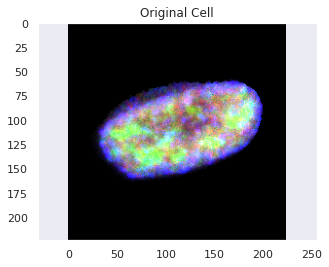

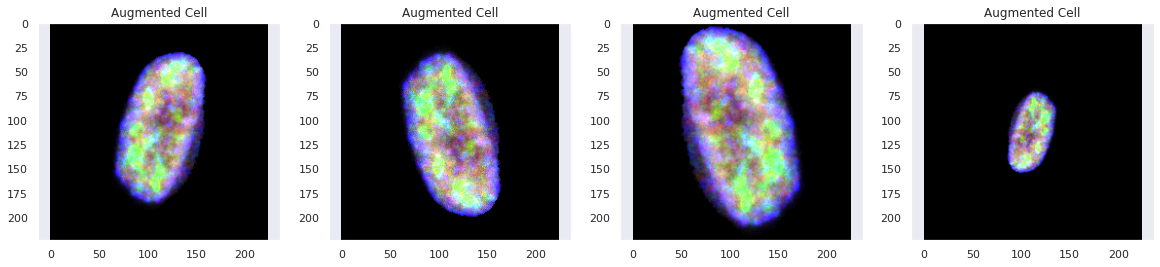

In [17]:
# Get one image from the training dataset
image, target = next(iter(train_data))
# Visualize the original vs. random flipping and rotations
visualize_cell(image,target)

Prepare datasets for training the CNN:

In [18]:
BATCH_SIZE = p['BATCH_SIZE']
buffer_size = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [19]:
# Init models class
models = predef_models()

# Select model
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)
model = models.select_model(model_name=p['model_name'], 
                            input_shape=img_shape,
                            conv_reg=p['conv_reg'],
                            dense_reg=p['dense_reg'],
                            pre_training=p['pre_training'],
                            freez_pretrain=p['freez_pretrain']
                           )

Xception selected!
Regularization:
conv_l1_reg: 0, conv_l2_reg: 0
dense_l1_reg: 0, dense_l2_reg: 0


Select the loss function and build the model:

In [20]:
# Select the loss function
if p['loss'] == 'mse':
    loss = tf.keras.losses.MeanSquaredError()
    
elif p['loss'] == 'huber':
    loss = tf.keras.losses.Huber(delta=1.0)
msg = '{} loss function selected. Building the model...'.format(p['loss'])
logging.info(msg)
print(msg)

metrics = ['mse', 'mean_absolute_error']
model.compile(optimizer=Adam(learning_rate=p['learning_rate']),
              loss=loss,
              metrics=metrics
             )
msg = 'Model compiled!'
logging.info(msg)

huber loss function selected. Building the model...


Take a look into the model architecture and number of parameters:

In [21]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 224, 224, 33 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 9504        InputLayer[0][0]                 
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [22]:
# Finish stdout duplication
TeeLog.close()

Redirect the systems standard output to the logfile, so we can see the training process in the server:

Set callback to save best model:

In [23]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoints_path+'/checkpoint',
#    save_weights_only=True,
    filepath=checkpoints_path+'/best_model',
    save_weights_only=False,
    #monitor='val_loss',
    monitor='val_mean_absolute_error',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
)
callbacks = [model_checkpoint_callback]

Set tensorboard config (if active):

In [24]:
if p['tensorboard']:
    tb_dir_path = p['log_file_name'][:-4]+'_tensorboard'
    try:
        shutil.rmtree(tb_dir_path)
    except OSError as e:
        msg  = 'Tensorboard log dir {} could not be deleted!\n\nOSError: {}'.format(tb_dir_path, e)
        logging.error(msg)
        print(msg)
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir_path, histogram_freq=1)
    callbacks.append(tensorboard_callback)
    
    msg = 'Tensorboard file: {}'.format(tb_dir_path)
    logging.info('\n\n'+msg+'\n\n')
    print(msg)

Train the model:

In [25]:
msg = 'Starting model training...'
logging.info(msg)

In [26]:
# if LR_SCHEDULE given, then init lr scheduler callback
if 'LR_SCHEDULE' in p.keys():
    finish_warmup_and_lr_schedule = lr_schedule_Callback(utils.lr_schedule, p['LR_SCHEDULE'])
    callbacks.append(finish_warmup_and_lr_schedule)

In [ ]:
# Save time before training
tic = time.time()
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)

# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=p['number_of_epochs'],
                    callbacks=callbacks,
                    verbose=p['verbose_level'],
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )
toc = time.time()
print('Training time (in mins): {}'.format((toc-tic)/60))

Epoch 1/300
 4/16 [======>.......................] - ETA: 3:13 - loss: 381.0662 - mse: 149269.6562 - mean_absolute_error: 381.5662

In [ ]:
# Finish stdout duplication
TeeLog.close()

In [ ]:
msg = 'Saiving trained model'
logging.info(msg)

# Save model
model.save(model_path)

# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history.history, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [ ]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

In [ ]:
plt.figure(figsize=(10,18))
models_functions.plot_loss(history.history, metrics, p)

# First evaluation: Last model

## Evaluate the whole Dataset

In [ ]:
del(train_data, val_data, test_data)
del(dataset, metadata)

In [ ]:
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [ ]:
BATCH_SIZE = p['BATCH_SIZE']
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
columns = ['y', 'y_hat', 'mapobject_id_cell', 'set']
targets_df = pd.DataFrame(columns=columns)

dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
for ds, dsn in zip(dss, ds_names):
    for cells in ds:
        cell_ids = [cell_id.decode() for cell_id in cells['mapobject_id_cell'].numpy()]
        cell_ids = np.asarray(cell_ids).reshape(-1,1)
        cell_imgs, Y = filter_channels(cells['image'], cells['target'])
        Y = Y.numpy()
        Y_hat = model.predict(cell_imgs)
        temp_df = pd.DataFrame(np.concatenate((Y, Y_hat), axis=1), columns=['y', 'y_hat'])
        temp_df['mapobject_id_cell'] = cell_ids
        temp_df['set'] = dsn
        targets_df = pd.concat((targets_df, temp_df), axis=0, ignore_index=True)

In [ ]:
# Add perturbation info to the targets df
with open(os.path.join(p['pp_path'], 'metadata.csv'), 'r') as file:
    row_data_metadata = pd.read_csv(file)
    row_data_metadata.mapobject_id_cell = row_data_metadata.mapobject_id_cell.astype(str)
per_df = row_data_metadata[['mapobject_id_cell', 'perturbation']]
targets_df = targets_df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
)
targets_df

## Plot results
Now lets see how our model performs.

In [ ]:
models_functions.plot_error_dist(df=targets_df, y_true='y', y_models=['y_hat'])

In [ ]:
models_functions.plot_y_dist(df=targets_df, y_true='y', y_hat='y_hat')

In [ ]:
# Residual plot
models_functions.plot_residuals(df=targets_df, y_true='y', y_hat='y_hat', hue='set')

In [ ]:
# Target vs predicted
models_functions.plot_y_vs_y_hat(df=targets_df, y_true='y', y_hat='y_hat', hue='set')

In [ ]:
metric_values = models_functions.get_metrics(df=targets_df, y_true='y', y_hat='y_hat')
metric_values

# Second evaluation: Best model

In [ ]:
# Load best weights
#model.load_weights(checkpoints_path+'/checkpoint')
model.load_weights(os.path.join(checkpoints_path, 'best_model/variables/variables'))

## Evaluate the whole Dataset

In [ ]:
columns = ['y', 'y_hat', 'mapobject_id_cell', 'set']
targets_df = pd.DataFrame(columns=columns)

dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
for ds, dsn in zip(dss, ds_names):
    for cells in ds:
        cell_ids = [cell_id.decode() for cell_id in cells['mapobject_id_cell'].numpy()]
        cell_ids = np.asarray(cell_ids).reshape(-1,1)
        cell_imgs, Y = filter_channels(cells['image'], cells['target'])
        Y = Y.numpy()
        Y_hat = model.predict(cell_imgs)
        temp_df = pd.DataFrame(np.concatenate((Y, Y_hat), axis=1), columns=['y', 'y_hat'])
        temp_df['mapobject_id_cell'] = cell_ids
        temp_df['set'] = dsn
        targets_df = pd.concat((targets_df, temp_df), axis=0, ignore_index=True)

In [ ]:
# Add perturbation info to the targets df
with open(os.path.join(p['pp_path'], 'metadata.csv'), 'r') as file:
    row_data_metadata = pd.read_csv(file)
    row_data_metadata.mapobject_id_cell = row_data_metadata.mapobject_id_cell.astype(str)
per_df = row_data_metadata[['mapobject_id_cell', 'perturbation']]
targets_df = targets_df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
)
targets_df

In [ ]:
# Sava targets info
with open(os.path.join(base_path, 'targets.csv'), 'w') as file:
    targets_df.to_csv(file, index=False)

## Plot results
Now lets see how our model performs.

In [ ]:
models_functions.plot_error_dist(df=targets_df, y_true='y', y_models=['y_hat'])

In [ ]:
models_functions.plot_y_dist(df=targets_df, y_true='y', y_hat='y_hat')

In [ ]:
# Residual plot
models_functions.plot_residuals(df=targets_df, y_true='y', y_hat='y_hat', hue='set')

In [ ]:
# Target vs predicted
models_functions.plot_y_vs_y_hat(df=targets_df, y_true='y', y_hat='y_hat', hue='set')

In [ ]:
metric_values = models_functions.get_metrics(df=targets_df, y_true='y', y_hat='y_hat')

# Sava metrics info
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metric_values.to_csv(file, index=False)
metric_values

In [ ]:
msg = 'Notebook execution finished!'
logging.info(msg)